In [1]:
import os
import json
import glob as glob
import numpy as np
import datetime
import utils
import shutil
import tensorboard
import time
import cv2
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
%load_ext tensorboard
now = datetime.datetime.now()
date_string = now.strftime("%Y-%m-%d_%H-%M-%S")
os.mkdir(f'logs_yolo/yolov5-{date_string}')
curr_dir = f'logs_yolo/yolov5-{date_string}'
np.random.seed(2024)

In [2]:
t1 = time.perf_counter()

In [3]:
TRAIN = True
EPOCHS = 100
star = 10
BH = 1
num_photo = 1000
batch_size = 16
size = 1024
BH_lower = 64
BH_upper = 75
wl = 100e-9
D = 6.5
F = 131.4
angular_pixel_size_input_image = 3e-5

In [4]:
data_dirs = glob.glob(f"tele_datasets/stars{star}_BH{BH}_num{num_photo}_rect_wl{wl:.3e}_*{F}"
                      f"*{angular_pixel_size_input_image:.2e}_BHSize{BH_lower}-{BH_upper}")
assert len(data_dirs) != 0, 'Empty'
assert len(data_dirs) == 1, "Please specify more parameters!"
data_dir = data_dirs[0]
data_dir

'tele_datasets\\stars10_BH1_num1000_rect_wl1.000e-07_D6.50_F131.4_AS3.00e-05_BHSize64-75'

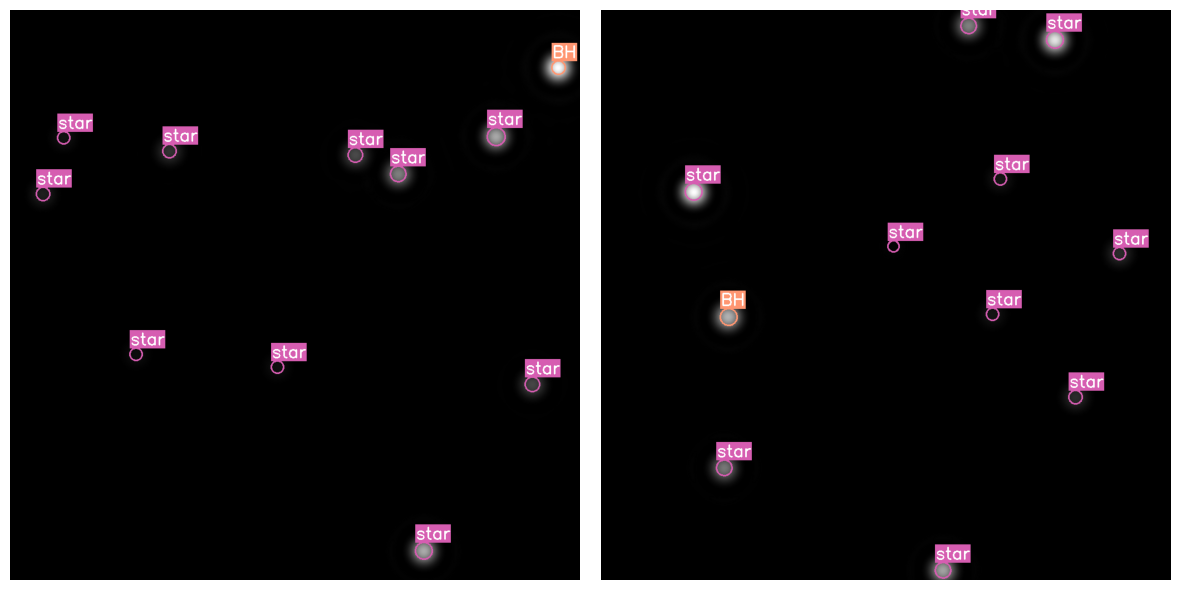

In [5]:
# Visualize a few training images.
utils.labels_plot(
    image_paths=f'{data_dir}/train/images/*',
    label_paths=f'{data_dir}/train/labels/*',
    num_samples=2, curr_dir=curr_dir
)

In [6]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [7]:
%tensorboard --logdir yolov5/runs/train

Reusing TensorBoard on port 6009 (pid 28900), started 1:42:34 ago. (Use '!kill 28900' to kill it.)

In [8]:
%cd yolov5

c:\Users\fyq\Documents\deepshadow\yolov5


In [9]:
RES_DIR = set_res_dir()
# yolov5s.pt
yaml = os.path.join(data_dir, 'data.yaml')
if TRAIN:
    !python train.py --data ../{yaml} --weights yolov5s.pt --img {size} --epochs {EPOCHS} \
    --batch-size {batch_size} --name {RES_DIR} --cache
else:
    subprocess.run(f'python train.py --weights yolov5s.pt --data {data_dir}/data.yaml --img {size}'
                   f'--batch-size {batch_size} --name {RES_DIR} --evolve 1000 --cache', shell=True, capture_output=True)
# p.wait()

Current number of result directories: 0
results_1


In [ ]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

In [ ]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
RES_DIR

'results_1'

In [ ]:
try:
    os.mkdir('../inference')
except FileExistsError:
    shutil.rmtree('../inference')
    os.mkdir('../inference')

In [ ]:
inference_lst = list(np.random.choice(os.listdir(f"..\\{data_dir}\\train\\images"), 10))

In [ ]:
for i in inference_lst:
    shutil.copy(f'../{data_dir}/train/images/{i}', f'../inference/{i}')

In [ ]:
inference(RES_DIR, '../inference')

Current number of inference detection directories: 0
inference_1


detect: weights=['runs/train/results_1/weights/best.pt'], source=../inference, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=inference_1, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2024-1-26 Python-3.9.18 torch-1.9.0+cu111 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)

Traceback (most recent call last):
  File "c:\Users\fyq\Documents\deepshadow\yolov5\detect.py", line 309, in <module>
    main(opt)
  File "c:\Users\fyq\Documents\deepshadow\yolov5\detect.py", line 304, in main
    run(**vars(opt))
  File "c:\Users\fyq\.conda\envs\deepshadow\lib\site-packages\torch\autograd\grad_mode.py", line 28, in decorate_context
    return func(*args, **kwargs)
  File "c:\Users\fyq\D

'inference_1'

In [ ]:
t2 = time.perf_counter()

In [ ]:
shutil.move('runs/', f'../{curr_dir}')

'../logs_yolo/yolov5-2024-01-26_23-07-50\\runs'

In [ ]:
curr_dir

'logs_yolo/yolov5-2024-01-26_23-07-50'

In [ ]:
result = pd.read_csv(glob.glob(f'../{curr_dir}/**/*/results*.csv', recursive=True)[-1])
result.columns = result.columns.str.strip()
df_sorted = result.sort_values(by='metrics/mAP_0.5', ascending=False)
best = df_sorted.iloc[0, :]

IndexError: list index out of range

In [ ]:
box_loss = best['val/box_loss']
obj_loss = best['val/obj_loss']
cls_loss = best['val/cls_loss']
precision= best['metrics/precision']
recall = best['metrics/recall']
mAP_05 = best['metrics/mAP_0.5']
mAP_0595 = best['metrics/mAP_0.5:0.95']

In [ ]:
# !cat {data_dir}/tele_config.json

In [ ]:
with open(f"../{data_dir}/telescope_config.json", "r") as json_file:
    telescope_config = json.load(json_file)

with open(f"../{data_dir}/stars_config.json", "r") as json_file:
    stars_config = json.load(json_file)

In [ ]:
!pip install openpyxl

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ----------- --------------------------- 71.7/250.0 kB 3.8 MB/s eta 0:00:01
     ----------- --------------------------- 71.7/250.0 kB 3.8 MB/s eta 0:00:01
     ---------------------------------- --- 225.3/250.0 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 250.0/250.0 kB 1.7 MB/s eta 0:00:00


In [ ]:
a = {
    'Model_name': 'yolov5',
    'Batch_size': batch_size,
    'Resolution': size,
    'date': date_string,
    'Training Epoch': EPOCHS,
    'box_loss' : box_loss,
    'obj_loss' : obj_loss,
    'cls_loss' : cls_loss,
    'precision' : precision,
    'recall' : recall,
    'mAP_0.5' : mAP_05,
    'mAP_0.5:0.95': mAP_0595,
    'No. training': num_photo / 5 *4,
    'No. testing': num_photo / 5,
    'No. star': star,
    'No. BH': BH,
    'Time': t2 - t1,
    'BH_lower_size': stars_config['BHS_lower_size'],
    'BH_upper_size': stars_config['BH_upper_size'],
    'angular_pixel_size_input_image': telescope_config['angular_pixel_size_input_image'],
    'D': telescope_config['telescope_diameter_m'],
    'F': telescope_config['telescope_focal_length_m'],
    'wavelength': telescope_config['wavelength'],
    'init_size': 3072,
    'CCD_pixel_size': telescope_config['CCD_pixel_size'],
    'CCD_pixel_count': telescope_config['CCD_pixel_count']
}

df = pd.read_excel('../logs_yolo/results.xlsx')
df = pd.concat([df, pd.DataFrame([a])], ignore_index=True)
df.to_excel('../logs_yolo/results.xlsx', index=False)

In [ ]:
df

,date,Model_name,Batch_size,Resolution,No. training,No. testing,Training Epoch,More,box_loss,obj_loss,...,Time,BH_lower_size,BH_upper_size,init_size,wavelength,D,F,angular_pixel_size_input_image,CCD_pixel_size,CCD_pixel_count
0,2024-01-15_08-31-37,yolov5,32,1000,NaN,NaN,200,NaN,0.010316,0.070310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-15_13-43-25,yolov5,32,900,NaN,NaN,300,NaN,0.008457,0.055789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-18_14-59-05,yolov5,16,1000,NaN,NaN,300,NaN,0.009994,0.083809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-18_17-38-36,yolov7,8,800,400.0,100.0,300,NaN,0.035080,0.017080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-18_21-19-40,yolov5,16,1000,800.0,200.0,300,NaN,0.009994,0.083809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2024-01-18_23-03-06,yolov5,16,1000,4000.0,1000.0,2000,NaN,0.009792,0.080352,...,1903.525178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2024-01-19_09-33-44,yolov5,16,1000,4000.0,1000.0,250,NaN,0.010062,0.084277,...,1464.442135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2024-01-19_20-42-32,yolov5,16,1000,8000.0,2000.0,200,NaN,0.005050,0.005558,...,22788.763659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2024-01-20_09-44-30,yolov5,16,1000,800.0,200.0,200,NaN,0.008687,0.026217,...,2349.951691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2024-01-20_11-05-05,yolov5,16,1000,4000.0,1000.0,200,NaN,0.006175,0.019700,...,24697.725679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
